# Part one - defining the problem: class imbalance and knn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from seaborn import countplot, kdeplot, heatmap
from tqdm import tqdm


KNN models, specifically KNN classifiers, are exellent at predicting on balanced datasets. However, while I was trying to predict the length of stay from a dataset containing patient data, I found that my model's were performing poorly.

In [43]:
# training dataframe from synthetic dataset
df = pd.read_csv('train_data.csv')


In [44]:
df.head(1)

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10


<Axes: xlabel='Stay', ylabel='count'>

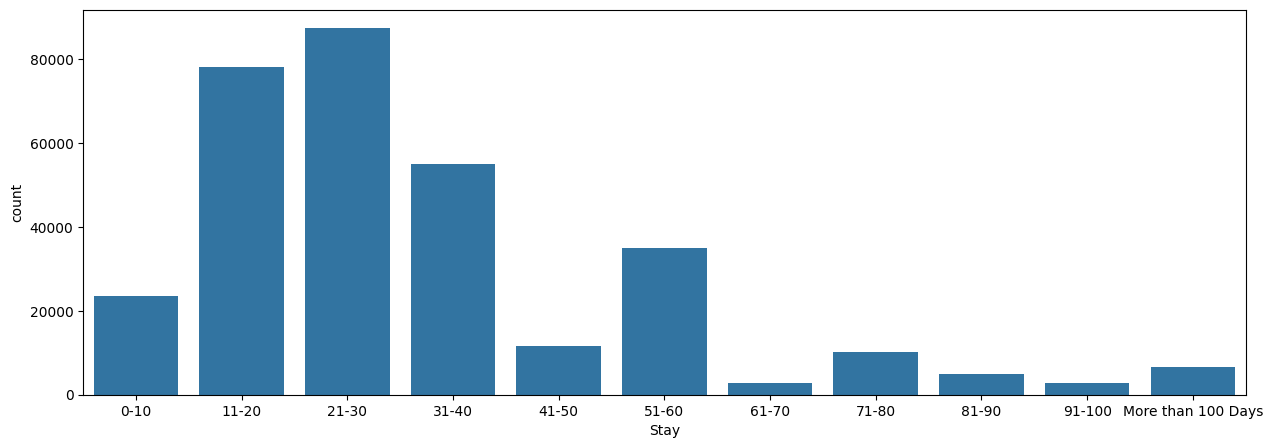

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
countplot(data=df, x=df["Stay"].sort_values(), ax=ax)

Taking a look at the training data, and specifically when looking at the target "Stay", we can see that Stay suffers from class imbalance, which will be a problem when using a classic knn model. Let's explore why by training and testing a knn model.

I have done EDA in much greater detail in explore.ipynb, where I discuss why I have dropped and trainsformed predictors in the way I have. This is not mandatory reading to continue through this workbook.

In [46]:
def remove_fields(cols:list, columns_to_drop):

    cols2 = []

    for col in cols:
        if not col in columns_to_drop:
            cols2.append(col)
            # print(cols)

    return cols2

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df_test = pd.read_csv("test_data.csv")

columns_to_drop = [
    "Hospital_region_code",
    "Ward_Facility_Code",
    "case_id",
    "patientid",
    "Hospital_code",
    "City_Code_Patient",
    "Admission_Deposit",
    # "Available Extra Rooms in Hospital",
    "Bed Grade",
    "City_Code_Hospital",
    "Visitors with Patient",
    "Hospital_type_code",
    # "Type of Admission",
    "Department"
]

df = df.drop(columns_to_drop, axis=1)
df = df.sample(10_000)

categoric_columns = [
    'Hospital_type_code',
    'City_Code_Hospital',
    'Department', 
    'Ward_Type',
    'City_Code_Patient', 
    'Type of Admission'
]

ordinal_columns = [
    'Bed Grade',
    'Severity of Illness'
]

cont_columns = [
    'Available Extra Rooms in Hospital',
    'Visitors with Patient',
    'Age',
    'Admission_Deposit'
]

categoric_columns = remove_fields(categoric_columns, columns_to_drop) 
ordinal_columns = remove_fields(ordinal_columns, columns_to_drop)
cont_columns = remove_fields(cont_columns, columns_to_drop)

X = df.drop('Stay', axis=1)
y = df['Stay']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, random_state=33)

col_transformer = ColumnTransformer(
    transformers=[
        ('target', TargetEncoder(), categoric_columns),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_columns)
    ]
)

knn_pipeline_list = [
    ('col_transform', col_transformer),
    ('scaler', MinMaxScaler()),
    ('knn_imputer', KNNImputer(n_neighbors=10, weights='distance')),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
]

knn_pipeline = Pipeline(knn_pipeline_list)

knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)
np.unique(y_pred)

array(['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '71-80'],
      dtype=object)

Just to summarise the above code, I dropped a large number of columns to remove irrelevent data such as patient ID, reduce the variance of the model and avoid the curse of dimensionality, before creating a pipeline that imputes and transforms the remaining features. I then split the data into training and testing sets, fitted the model and predicited on the test set. 

When we look at the unique classes in our predictions, we see that several lengths of stay are missing.

Just to make this clearer, below is a heatmap displaying the confusion matrix between y_pred and y_test. We can see that for the under-represented classes, we never made correct predictions, or any predictions at all.

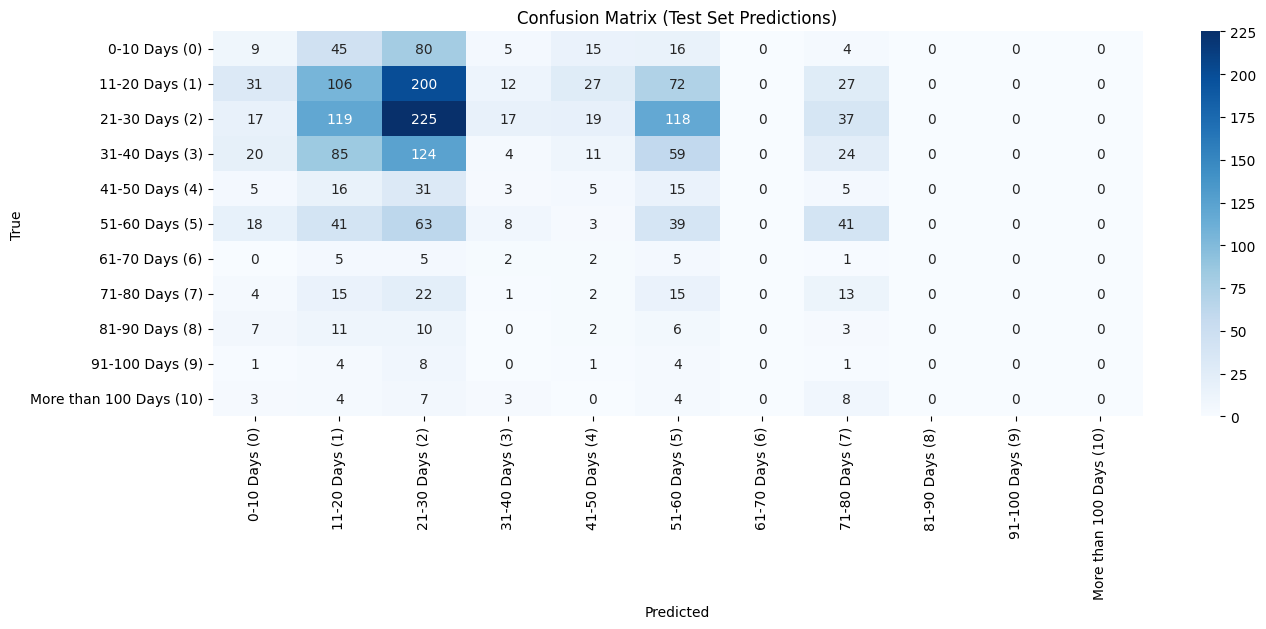

In [50]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

class_labels = [
    "0-10 Days (0)", "11-20 Days (1)", "21-30 Days (2)", "31-40 Days (3)",
    "41-50 Days (4)", "51-60 Days (5)", "61-70 Days (6)", "71-80 Days (7)",
    "81-90 Days (8)", "91-100 Days (9)", "More than 100 Days (10)"
]

# Visualize the confusion matrix with class labels
plt.figure(figsize=(15, 5))
heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set Predictions)')
plt.show()

While we are currently working with a synthetic dataset, this does show quite nicely one of the shortcomings of knn models: predicting on unblananced datasets.

In my research into how to solve this issue, I came across a paper titled "Effective k‑nearest neighbor models for data
classification enhancement". This paper claimed to successfully implemented knn models that performed well on unbalanced data, so naturally I decided to read further into their work.

# Part 2: Implementing a novel knn model

In the above paper, the authors discuss the various ways in which data can frustrate the performance of a knn model, including class imbalance. 

To solve this issue, they propose the use of a proximal ratio (PR) weighting scheme, which would in theory enable a knn model predict based on how an instance of a target class is clustered amongst other instances of it's class, and make predictions accordingly. 

### Calculating and visualising PR.

